# Links to dataset information

**UCI**:
- __[adult](http://archive.ics.uci.edu/ml/datasets/Adult)__
- __[annealing](https://archive.ics.uci.edu/ml/datasets/Annealing)__
- __[audiology-std](https://archive.ics.uci.edu/ml/datasets/Audiology+%28Standardized%29)__
- __[bank](https://archive.ics.uci.edu/ml/datasets/Bank%2BMarketing)__
- __[bankruptcy](http://archive.ics.uci.edu/ml/datasets/Qualitative_Bankruptcy)__
- __[car](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation)__
- __[chess-krvk](https://archive.ics.uci.edu/ml/datasets/Chess+%28King-Rook+vs.+King%29)__
- __[chess-krvkp](http://archive.ics.uci.edu/ml/datasets/Chess+%28King-Rook+vs.+King-Pawn%29)__
- __[congress-voting](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)__
- __[contrac](https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice)__
- __[credit-approval](http://archive.ics.uci.edu/ml/datasets/Credit+Approval)__
- **unsure about this one**: __[ctg](https://www.kaggle.com/akshat0007/fetalhr)__
- __[cylinder-bands](http://archive.ics.uci.edu/ml/datasets/Cylinder+Bands)__
- __[dermatology](https://archive.ics.uci.edu/ml/datasets/Dermatology)__
- __[german_credit](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29)__
- __[heart-cleveland](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)__
- __[ilpd](http://archive.ics.uci.edu/ml/datasets/ILPD+%28Indian+Liver+Patient+Dataset%29)__
- __[mammo](https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)__
- __[mushroom](https://archive.ics.uci.edu/ml/datasets/Mushroom)__
- __[wine](https://archive.ics.uci.edu/ml/datasets/wine)__
- __[wine_qual](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)__

Others:
- __[texas](https://www.dshs.texas.gov/thcic/hospitals/UserManual1Q2013.pdf)__
- __[IEEECIS](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203)__


# Imports

In [1]:
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm

In [2]:
from src.loader import load_dataset
from src.models import *
from src.preprocessing import processing_pipeline
from src.feature_selection import forward_stepwise_regression
from src.vulnerabilities import *

In [3]:
uci_datasets = ['adult', 'annealing', 'audiology-std', 'bank', 'bankruptcy', 'car',
                'chess-krvk', 'chess-krvkp', 'congress-voting', 'contrac', 'credit-approval',
                'ctg', 'cylinder-bands', 'dermatology', 'german_credit', 'heart-cleveland',
                'ilpd', 'mammo', 'mushroom', 'wine', 'wine_qual']

all_datasets = uci_datasets + ['texas', 'ieeecis']

# Model substitutes

In [4]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [5]:
results = []

for dataset in ['bankruptcy', 'car', 'congress-voting', 'credit-approval',
                'dermatology','german_credit', 'mammo']:
    
    # Load the data
    X, y = load_dataset(name=dataset)
    
    X_train, X_test, y_train, y_test = processing_pipeline(X, y, train_size=0.9)

    # Construct first SRR on train set to do feature selection
    srr = SRR(k=3, M=5)
    srr.fit(X_train, y_train)
    
    # Construct the alternate models based on the SRR trained on train set
    rlr = RoundedLogisticRegression.from_srr(srr)
    swcv = SRRWithoutCrossValidation.from_srr(srr)

    for i in tqdm(list(chunks(np.random.permutation(X_train.index), 5))[:50]):
        
        X_r = X_train.drop(i)
        y_r = y_train.drop(i)
        
        srr = SRR(k=3, M=5)        
        start = time.time()
        srr.fit(X_r, y_r)
        srr_time = time.time() - start
        srr_pred = srr.predict(X_r)

        for model in [rlr, swcv]:
            start = time.time()
            model.fit(X_r, y_r)
            abs_time = time.time() - start
            speedup = srr_time / abs_time
            rel_acc = accuracy_score(srr_pred, model.predict(X_r))
                  
            results.append([dataset, model.name(), speedup, rel_acc])

results = pd.DataFrame(results, dtype=float, columns=['dataset', 'model', 'speedup', 'faithfulness'])
results

Loading bankruptcy...


100%|██████████| 45/45 [00:20<00:00,  2.20it/s]


Loading car...


100%|██████████| 50/50 [00:47<00:00,  1.04it/s]


Loading congress-voting...


100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


Loading credit-approval...


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


Loading dermatology...


100%|██████████| 50/50 [01:16<00:00,  1.54s/it]


Loading german_credit...


100%|██████████| 50/50 [00:54<00:00,  1.08s/it]


Loading mammo...


100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


,dataset,model,speedup,faithfulness
0,bankruptcy,Rounded Logistic Regression,7.835015,1.000000
1,bankruptcy,SRR Without Cross-Validation,3.057613,1.000000
2,bankruptcy,Rounded Logistic Regression,7.452168,1.000000
3,bankruptcy,SRR Without Cross-Validation,2.694175,1.000000
4,bankruptcy,Rounded Logistic Regression,7.508127,1.000000
...,...,...,...,...
685,mammo,SRR Without Cross-Validation,6.978383,0.899884
686,mammo,Rounded Logistic Regression,15.939263,1.000000
687,mammo,SRR Without Cross-Validation,6.532176,1.000000
688,mammo,Rounded Logistic Regression,15.375236,0.898719


In [6]:
aggregated = results.groupby(['model', 'dataset'])[['speedup', 'faithfulness']].mean().reset_index()

In [8]:
aggregated.to_csv('speedup.csv')

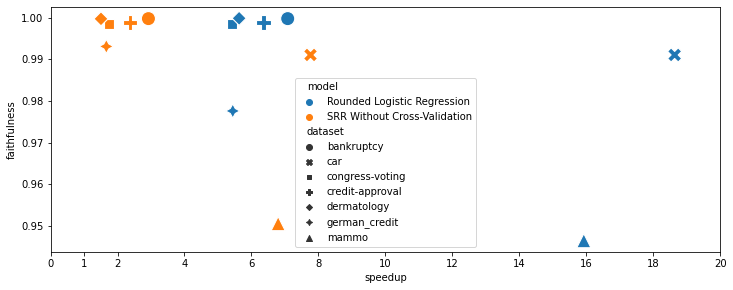

In [14]:
fig = plt.figure(figsize=(12, 4.5))

ax = sns.scatterplot(x='speedup', y='faithfulness', style='dataset', hue='model',
                     data=aggregated, figure=fig, s=200)

ax.set_xticks([1] + list(range(0, 22, 2)));

# Test number of removals vs attack time

In [17]:
dataset = 'bankruptcy'
print(f"-> {dataset} dataset")
# Load the data
X, y = load_dataset(name=dataset)

# Apply the processing pipeline
X_train, X_test, y_train, y_test = processing_pipeline(X, y)

# Construct and train Select-Regress-Round model
original_srr = SRR(k=3, M=5)
original_srr.fit(X_train, y_train, verbose=1)

print(original_srr)

-> bankruptcy dataset
Loading bankruptcy...
Selected features competitiveness, credibility, financial_flex
Logistic model accuracy of 100.0 % on the training set (baseline 57.3 %)
Select-Regress-Round (SRR) [k=3, M=5]

         Feature Category  Score
 competitiveness        A      0
 competitiveness        N      5
 competitiveness        P     -2
     credibility        A      0
     credibility        N      3
     credibility        P      0
  financial_flex        A      0
  financial_flex        N      2
  financial_flex        P      0

Model's bias: -4

Predict class 1 if sum of scores and bias is >= 0, otherwise predict 0.


### Removing credibility

In [8]:
%%time
removals = poisoning_attack_point_removal(original_srr, X_train, y_train, 
                                          feature='credibility',
                                          goal='remove_feature', col='normal',
                                          use_substitute=True, use_stats=False)
f'{len(removals)} removals: {removals}'

100%|██████████| 221/221 [00:19<00:00, 11.53it/s]



Attack successful! :D
CPU times: user 6min 38s, sys: 5.88 s, total: 6min 44s
Wall time: 1min 40s


'5 removals: [249, 157, 191, 192, 100]'

In [6]:
%%time
removals = poisoning_attack_point_removal(original_srr, X_train, y_train, 
                                          feature='credibility',
                                          goal='remove_feature', col='normal',
                                          use_substitute=False, use_stats=False)
f'{len(removals)} removals: {removals}'

100%|██████████| 211/211 [00:50<00:00,  4.22it/s]



Attack successful! :D
CPU times: user 1h 13min 28s, sys: 1min 26s, total: 1h 14min 54s
Wall time: 13min 20s


'15 removals: [249, 76, 106, 245, 187, 211, 215, 153, 54, 64, 58, 191, 192, 226, 157]'

### Removing financial_flex

In [18]:
%%time
removals = poisoning_attack_point_removal(original_srr, X_train, y_train, 
                                          feature='financial_flex',
                                          goal='remove_feature', col='normal',
                                          use_substitute=True, use_stats=False)
f'{len(removals)} removals: {removals}'

100%|██████████| 221/221 [00:19<00:00, 11.56it/s]



Attack successful! :D
CPU times: user 6min 27s, sys: 5.57 s, total: 6min 33s
Wall time: 1min 37s


'5 removals: [249, 191, 192, 157, 168]'

In [19]:
%%time
removals = poisoning_attack_point_removal(original_srr, X_train, y_train, 
                                          feature='financial_flex',
                                          goal='remove_feature', col='normal',
                                          use_substitute=False, use_stats=False)
f'{len(removals)} removals: {removals}'

100%|██████████| 221/221 [00:51<00:00,  4.30it/s]



Attack successful! :D
CPU times: user 24min 39s, sys: 29 s, total: 25min 8s
Wall time: 4min 31s


'5 removals: [192, 191, 249, 157, 168]'

### Nullifying financial_flex N

In [21]:
%%time
removals = poisoning_attack_point_removal(original_srr, X_train, y_train, 
                                          feature='financial_flex',
                                          category='N',
                                          goal='nullify', col='normal',
                                          use_substitute=True, use_stats=False)
f'{len(removals)} removals: {removals}'

100%|██████████| 223/223 [00:07<00:00, 29.21it/s]



Attack successful! :D
CPU times: user 25.8 s, sys: 167 ms, total: 26 s
Wall time: 22.5 s


'3 removals: [249, 191, 192]'

In [22]:
%%time
removals = poisoning_attack_point_removal(original_srr, X_train, y_train, 
                                          feature='financial_flex',
                                          category='N',
                                          goal='nullify', col='normal',
                                          use_substitute=False, use_stats=False)
f'{len(removals)} removals: {removals}'

100%|██████████| 224/224 [00:56<00:00,  3.94it/s]



Attack successful! :D
CPU times: user 10min 22s, sys: 12.5 s, total: 10min 35s
Wall time: 1min 52s


'2 removals: [192, 191]'

### Nullifying credibility N

In [23]:
%%time
removals = poisoning_attack_point_removal(original_srr, X_train, y_train, 
                                          feature='credibility',
                                          category='N',
                                          goal='nullify', col='normal',
                                          use_substitute=True, use_stats=False)
f'{len(removals)} removals: {removals}'

100%|██████████| 224/224 [00:07<00:00, 29.24it/s]



Attack successful! :D
CPU times: user 17.7 s, sys: 82.8 ms, total: 17.8 s
Wall time: 15.5 s


'2 removals: [191, 192]'

In [24]:
%%time
removals = poisoning_attack_point_removal(original_srr, X_train, y_train, 
                                          feature='credibility',
                                          category='N',
                                          goal='nullify', col='normal',
                                          use_substitute=False, use_stats=False)
f'{len(removals)} removals: {removals}'

100%|██████████| 216/216 [00:56<00:00,  3.80it/s]



Attack successful! :D
CPU times: user 50min 29s, sys: 59.5 s, total: 51min 29s
Wall time: 9min 12s


'10 removals: [157, 76, 106, 245, 187, 211, 153, 215, 191, 249]'

### Nullifying competitiveness N

In [25]:
%%time
removals = poisoning_attack_point_removal(original_srr, X_train, y_train, 
                                          feature='competitiveness',
                                          category='N',
                                          goal='nullify', col='normal',
                                          use_substitute=True, use_stats=False)
f'{len(removals)} removals: {removals}'

100%|██████████| 208/208 [00:06<00:00, 30.45it/s]



Attack successful! :D
CPU times: user 2min 27s, sys: 874 ms, total: 2min 28s
Wall time: 2min 6s


'18 removals: [215, 85, 106, 76, 153, 187, 245, 211, 65, 48, 63, 93, 64, 78, 54, 86, 92, 58]'

In [26]:
%%time
removals = poisoning_attack_point_removal(original_srr, X_train, y_train, 
                                          feature='competitiveness',
                                          category='N',
                                          goal='nullify', col='normal',
                                          use_substitute=False, use_stats=False)
f'{len(removals)} removals: {removals}'

100%|██████████| 206/206 [00:53<00:00,  3.82it/s]



Attack successful! :D
CPU times: user 1h 39min 41s, sys: 2min 3s, total: 1h 41min 45s
Wall time: 18min 48s


'20 removals: [215, 85, 76, 245, 153, 187, 211, 106, 191, 48, 86, 63, 58, 92, 78, 64, 54, 55, 65, 192]'